In [ ]:
pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,Dense,Dropout,Bidirectional,LSTM,GRU,Input,GlobalMaxPooling1D,LayerNormalization,Conv1D,MaxPooling1D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils

In [ ]:
data_path="comments_spam.csv"
data=pd.read_csv(data_path)
data.head()

,content,spam
0,Tuyệt vời cho các e bé nghe đáng kể vs anh đi ...,1
1,Chiến dịch tiêm vaccine Covid-19 toàn dân bắt ...,1
2,Nsnwnwnxnwkkxmmxmsmwmsmsxnndnwnxnsnwnznn ncn1m...,1
3,"Chất lượng sản phẩm ko như quảng cáo, kich thu...",0
4,"Giao hàng nhanh. Shop đóng gói cẩn thận, thế n...",0


In [ ]:
sentiment_data=pd.DataFrame(data,columns=["content","spam"])
sentiment_data=sentiment_data.dropna()
sentiment_data=sentiment_data.drop_duplicates(subset=["content"])
sentiment_data=sentiment_data.reset_index(drop=True)
print(sentiment_data.head())
print("sentiment_data shape: ", sentiment_data.shape)


                                             content  spam
0  Tuyệt vời cho các e bé nghe đáng kể vs anh đi ...     1
1  Chiến dịch tiêm vaccine Covid-19 toàn dân bắt ...     1
2  Nsnwnwnxnwkkxmmxmsmwmsmsxnndnwnxnsnwnznn ncn1m...     1
3  Chất lượng sản phẩm ko như quảng cáo, kich thu...     0
4  Giao hàng nhanh. Shop đóng gói cẩn thận, thế n...     0
sentiment_data shape:  (19852, 2)


In [ ]:
input_data=sentiment_data["content"].values
input_label=sentiment_data["spam"].values
label_data={"1":1,"0":0}
input_pre=[]
label_with_accent=[]
for idx,dt in enumerate(input_data):
    input_text_pre=list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
    input_text_pre=" ".join(input_text_pre)
    input_text_pre_no_accent=str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
    input_text_pre_accent=ViTokenizer.tokenize(input_text_pre)
    input_text_pre_no_accent=ViTokenizer.tokenize(input_text_pre_no_accent)
    input_pre.append(input_text_pre_accent)
    input_pre.append(input_text_pre_no_accent)
    label_with_accent.append(input_label[idx])
    label_with_accent.append(input_label[idx])
print("input_label size: ", len(input_label))
print("input_pre size: ", len(input_pre))


label size:  19852
label size:  39704


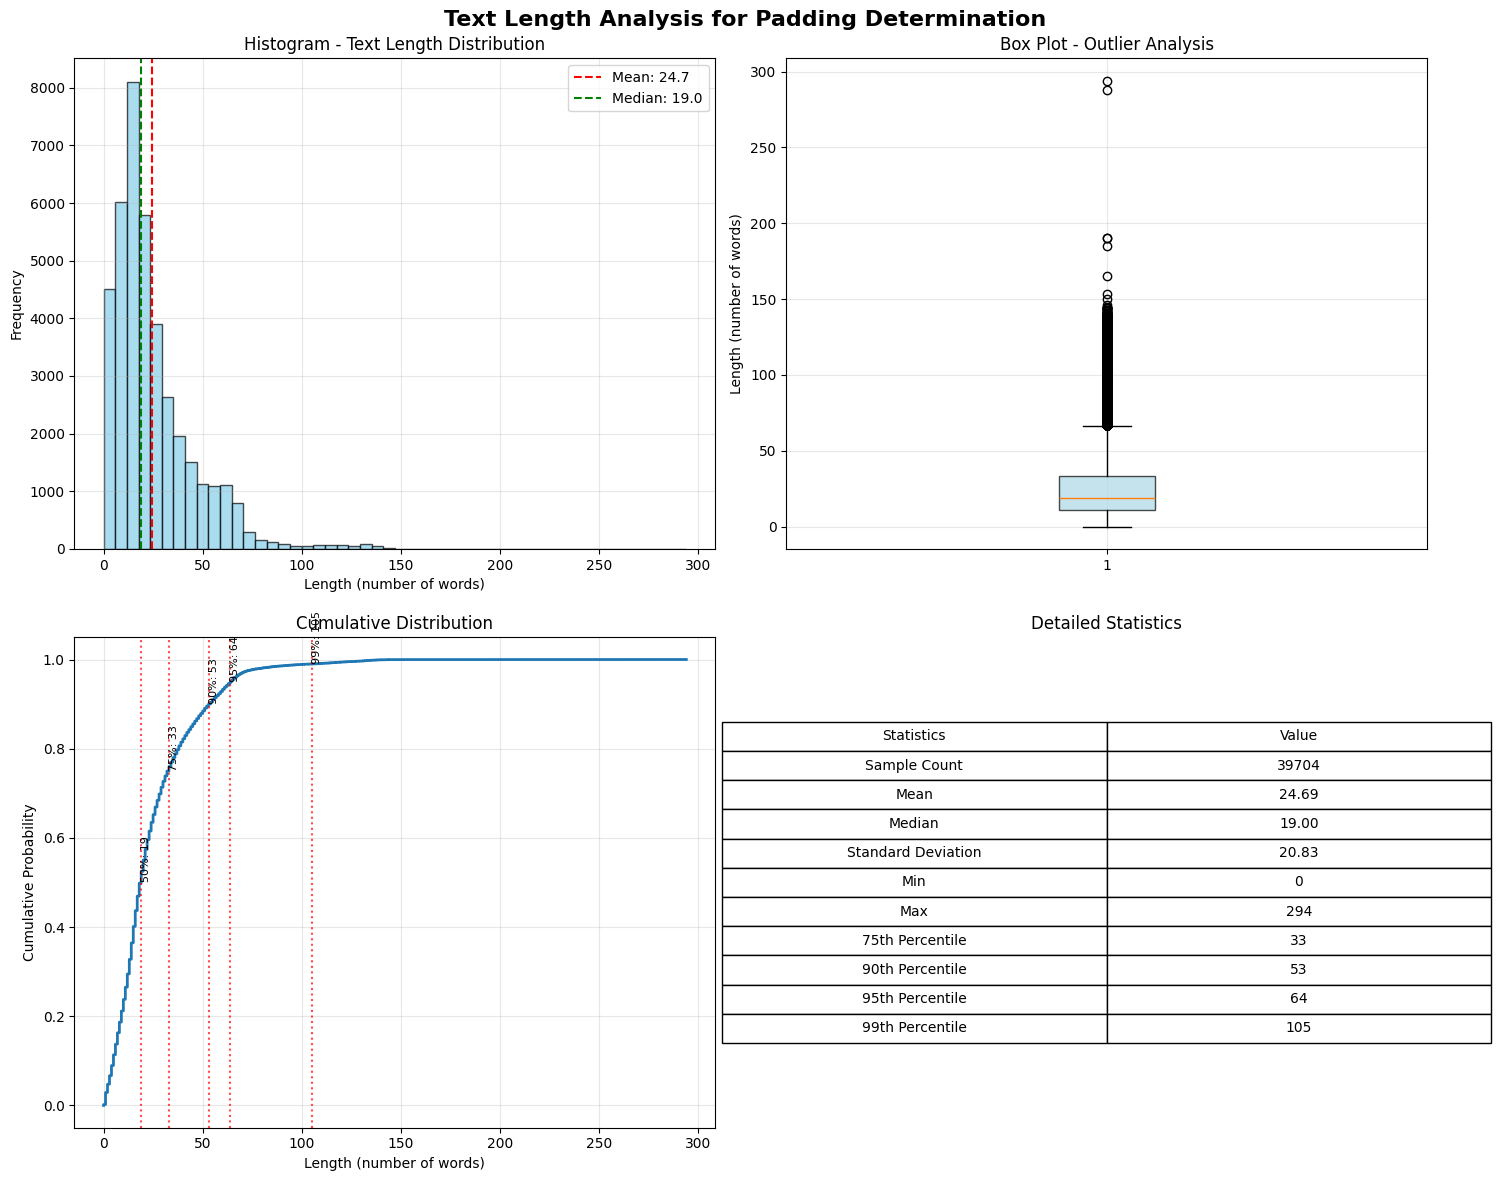

PADDING RECOMMENDATIONS FOR TRAINING:
Average length: 24.7 words
Median length: 19.0 words

Suggested padding options:
- Padding = 33: Covers 75% of data
- Padding = 53: Covers 90% of data (Recommended)
- Padding = 64: Covers 95% of data
- Padding = 105: Covers 99% of data

Notes:
- Too small padding: Loss of important information
- Too large padding: Increased training time and memory usage
- Usually choosing padding at 90-95% percentile is reasonable

Phân tích Outliers:
- Ngưỡng outlier (Q3 + 1.5*IQR): 66.0
- Số lượng outliers: 1607 (4.0%)
- Độ dài outliers: min=67, max=294


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



lengths = [len(text.split()) for text in input_pre]


fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Text Length Analysis for Padding Determination', fontsize=16, fontweight='bold')


axes[0, 0].hist(lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Histogram - Text Length Distribution')
axes[0, 0].set_xlabel('Length (number of words)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)


mean_length = np.mean(lengths)
median_length = np.median(lengths)
axes[0, 0].axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.1f}')
axes[0, 0].axvline(median_length, color='green', linestyle='--', label=f'Median: {median_length:.1f}')
axes[0, 0].legend()


axes[0, 1].boxplot(lengths, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[0, 1].set_title('Box Plot - Outlier Analysis')
axes[0, 1].set_ylabel('Length (number of words)')
axes[0, 1].grid(True, alpha=0.3)


sorted_lengths = np.sort(lengths)
cumulative_prob = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
axes[1, 0].plot(sorted_lengths, cumulative_prob, linewidth=2)
axes[1, 0].set_title('Cumulative Distribution')
axes[1, 0].set_xlabel('Length (number of words)')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].grid(True, alpha=0.3)

percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    val = np.percentile(lengths, p)
    axes[1, 0].axvline(val, color='red', linestyle=':', alpha=0.7)
    axes[1, 0].text(val, p/100, f'{p}%: {val:.0f}', rotation=90,
                    verticalalignment='bottom', fontsize=8)

stats_data = [
    ['Sample Count', len(lengths)],
    ['Mean', f'{mean_length:.2f}'],
    ['Median', f'{median_length:.2f}'],
    ['Standard Deviation', f'{np.std(lengths):.2f}'],
    ['Min', f'{min(lengths)}'],
    ['Max', f'{max(lengths)}'],
    ['75th Percentile', f'{np.percentile(lengths, 75):.0f}'],
    ['90th Percentile', f'{np.percentile(lengths, 90):.0f}'],
    ['95th Percentile', f'{np.percentile(lengths, 95):.0f}'],
    ['99th Percentile', f'{np.percentile(lengths, 99):.0f}']
]

axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=stats_data,
                        colLabels=['Statistics', 'Value'],
                        cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1, 1].set_title('Detailed Statistics')

plt.tight_layout()
plt.show()


print("="*60)
print("PADDING RECOMMENDATIONS FOR TRAINING:")
print("="*60)
print(f"Average length: {mean_length:.1f} words")
print(f"Median length: {median_length:.1f} words")
print()
print("Suggested padding options:")
print(f"- Padding = {int(np.percentile(lengths, 75))}: Covers 75% of data")
print(f"- Padding = {int(np.percentile(lengths, 90))}: Covers 90% of data (Recommended)")
print(f"- Padding = {int(np.percentile(lengths, 95))}: Covers 95% of data")
print(f"- Padding = {int(np.percentile(lengths, 99))}: Covers 99% of data")
print()
print("Notes:")
print("- Too small padding: Loss of important information")
print("- Too large padding: Increased training time and memory usage")
print("- Usually choosing padding at 90-95% percentile is reasonable")


q1 = np.percentile(lengths, 25)
q3 = np.percentile(lengths, 75)
iqr = q3 - q1
outlier_threshold = q3 + 1.5 * iqr
outliers = [x for x in lengths if x > outlier_threshold]

print(f"\nPhân tích Outliers:")
print(f"- Ngưỡng outlier (Q3 + 1.5*IQR): {outlier_threshold:.1f}")
print(f"- Số lượng outliers: {len(outliers)} ({len(outliers)/len(lengths)*100:.1f}%)")
if outliers:
    print(f"- Độ dài outliers: min={min(outliers)}, max={max(outliers)}")

In [ ]:
label_idx=[label_data[str(i)] for i in label_with_accent]
# to_categorical  ( one-hot encoding.)
label_tf=tf.keras.utils.to_categorical(label_idx,num_classes=len(label_data)) # Changed num_classes

tokenizer_data=Tokenizer(oov_token="<OOV>",filters='',split =' ')
tokenizer_data.fit_on_texts(input_pre)
tokenizer_data_text=tokenizer_data.texts_to_sequences(input_pre)
vec_data=pad_sequences(tokenizer_data_text,maxlen=60,padding="post")
print(" vec_data shape: ", vec_data.shape)
data_voca_size=len(tokenizer_data.word_index)+1
print("data_voca_size: ",data_voca_size)
print("label size: ", len(label_with_accent))

 vec_data shape:  (39704, 60)
data_voca_size:  25077
label size:  39704


In [ ]:
X_train,X_val,y_train,y_val=train_test_split(vec_data,label_tf,test_size=0.2,random_state=42)
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print(X_train)

X_train shape:  (28586, 60)
X_val shape:  (7941, 60)
X_test shape:  (3177, 60)
[[ 129  150   65 ...    0    0    0]
 [  79  446   26 ...    0    0    0]
 [  44   49    6 ...    0    0    0]
 ...
 [ 605 1299  314 ...    0    0    0]
 [   2    6    5 ...    0    0    0]
 [  14   72  107 ...    0    0    0]]


Unique label indices before one-hot encoding: [0 1]
Number of unique classes: 2
 vec_data shape:  (39704, 60)
data_voca_size:  25077
label size:  39704


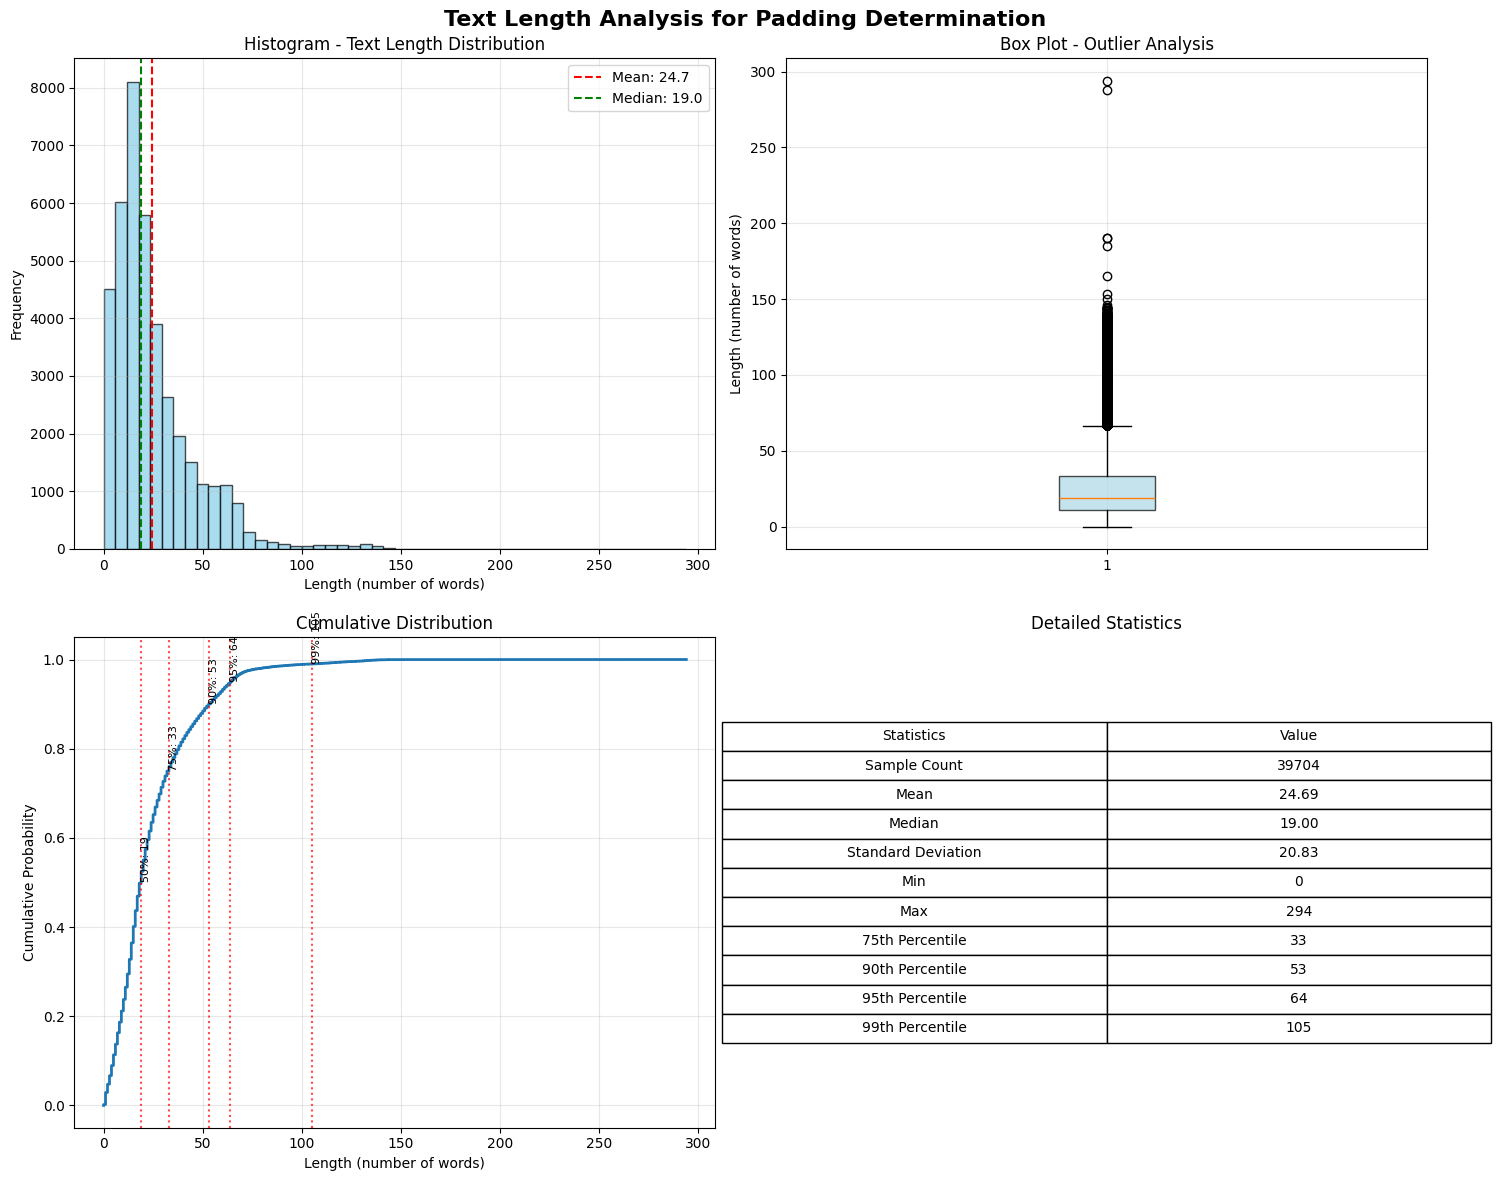

PADDING RECOMMENDATIONS FOR TRAINING:
Average length: 24.7 words
Median length: 19.0 words

Suggested padding options:
- Padding = 33: Covers 75% of data
- Padding = 53: Covers 90% of data (Recommended)
- Padding = 64: Covers 95% of data
- Padding = 105: Covers 99% of data

Notes:
- Too small padding: Loss of important information
- Too large padding: Increased training time and memory usage
- Usually choosing padding at 90-95% percentile is reasonable

Phân tích Outliers:
- Ngưỡng outlier (Q3 + 1.5*IQR): 66.0
- Số lượng outliers: 1607 (4.0%)
- Độ dài outliers: min=67, max=294
X_train shape:  (28586, 60)
X_val shape:  (7941, 60)
X_test shape:  (3177, 60)
[[ 129  150   65 ...    0    0    0]
 [  79  446   26 ...    0    0    0]
 [  44   49    6 ...    0    0    0]
 ...
 [ 605 1299  314 ...    0    0    0]
 [   2    6    5 ...    0    0    0]
 [  14   72  107 ...    0    0    0]]
(None, 15, 32)
(None, 32)
(None, 30, 64)
(None, 64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 60, 32)    │    802,464 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 60, 32)    │      3,104 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_16    │ (None, 30, 32)    │          0 │ conv1d_8[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 30, 32)    │          0 │ max_pooling1d_16… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 30, 32)    │      3,104 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_17    │ (None, 15, 32)    │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_9     │ (None, 60, 64)    │     12,672 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 15, 32)    │         64 │ max_pooling1d_17… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 30, 64)    │          0 │ bidirectional_9[… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 15, 32)    │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 64)    │        128 │ max_pooling1d_19… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ dropout_25[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 96)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 96)        │        192 │ concatenate_4[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 90)        │      8,730 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 90)        │          0 │ dense_20[0][0]  

 Total params: 841,970 (3.21 MB)

 Trainable params: 841,970 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.7460 - loss: 0.5547 - val_accuracy: 0.8388 - val_loss: 0.3785
Epoch 2/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.8598 - loss: 0.3523 - val_accuracy: 0.8493 - val_loss: 0.3804
Epoch 3/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.8936 - loss: 0.2648 - val_accuracy: 0.8674 - val_loss: 0.3380
Epoch 4/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.9238 - loss: 0.1998 - val_accuracy: 0.8747 - val_loss: 0.4214
Epoch 5/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.9418 - loss: 0.1561 - val_accuracy: 0.8705 - val_loss: 0.4639
Epoch 6/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.9489 - loss: 0.1348 - val_accuracy: 0.8777 - val_loss: 0.4387
Epoch 7/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9564 - loss: 0.1214 - val_accuracy: 0.8770 - val_loss: 0.5547
Epoch 8/10
894/894 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.9568 - loss: 0.1131 - 

In [ ]:
# %%
label_idx=[label_data[str(i)] for i in label_with_accent]

# Add a check to see unique values in label_idx
unique_labels = np.unique(label_idx)
print("Unique label indices before one-hot encoding:", unique_labels)
print("Number of unique classes:", len(unique_labels))

# Ensure num_classes is explicitly set to the number of unique classes
# to_categorical  ( one-hot encoding.)
label_tf=tf.keras.utils.to_categorical(label_idx, num_classes=len(unique_labels)) # Use the number of unique labels

tokenizer_data=Tokenizer(oov_token="<OOV>",filters='',split =' ')
tokenizer_data.fit_on_texts(input_pre)
tokenizer_data_text=tokenizer_data.texts_to_sequences(input_pre)
vec_data=pad_sequences(tokenizer_data_text,maxlen=60,padding="post")
print(" vec_data shape: ", vec_data.shape)
data_voca_size=len(tokenizer_data.word_index)+1
print("data_voca_size: ",data_voca_size)
print("label size: ", len(label_with_accent))
# %%
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



lengths = [len(text.split()) for text in input_pre]


fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Text Length Analysis for Padding Determination', fontsize=16, fontweight='bold')


axes[0, 0].hist(lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Histogram - Text Length Distribution')
axes[0, 0].set_xlabel('Length (number of words)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)


mean_length = np.mean(lengths)
median_length = np.median(lengths)
axes[0, 0].axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.1f}')
axes[0, 0].axvline(median_length, color='green', linestyle='--', label=f'Median: {median_length:.1f}')
axes[0, 0].legend()


axes[0, 1].boxplot(lengths, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[0, 1].set_title('Box Plot - Outlier Analysis')
axes[0, 1].set_ylabel('Length (number of words)')
axes[0, 1].grid(True, alpha=0.3)


sorted_lengths = np.sort(lengths)
cumulative_prob = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
axes[1, 0].plot(sorted_lengths, cumulative_prob, linewidth=2)
axes[1, 0].set_title('Cumulative Distribution')
axes[1, 0].set_xlabel('Length (number of words)')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].grid(True, alpha=0.3)

percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    val = np.percentile(lengths, p)
    axes[1, 0].axvline(val, color='red', linestyle=':', alpha=0.7)
    axes[1, 0].text(val, p/100, f'{p}%: {val:.0f}', rotation=90,
                    verticalalignment='bottom', fontsize=8)

stats_data = [
    ['Sample Count', len(lengths)],
    ['Mean', f'{mean_length:.2f}'],
    ['Median', f'{median_length:.2f}'],
    ['Standard Deviation', f'{np.std(lengths):.2f}'],
    ['Min', f'{min(lengths)}'],
    ['Max', f'{max(lengths)}'],
    ['75th Percentile', f'{np.percentile(lengths, 75):.0f}'],
    ['90th Percentile', f'{np.percentile(lengths, 90):.0f}'],
    ['95th Percentile', f'{np.percentile(lengths, 95):.0f}'],
    ['99th Percentile', f'{np.percentile(lengths, 99):.0f}']
]

axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=stats_data,
                        colLabels=['Statistics', 'Value'],
                        cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1, 1].set_title('Detailed Statistics')

plt.tight_layout()
plt.show()


print("="*60)
print("PADDING RECOMMENDATIONS FOR TRAINING:")
print("="*60)
print(f"Average length: {mean_length:.1f} words")
print(f"Median length: {median_length:.1f} words")
print()
print("Suggested padding options:")
print(f"- Padding = {int(np.percentile(lengths, 75))}: Covers 75% of data")
print(f"- Padding = {int(np.percentile(lengths, 90))}: Covers 90% of data (Recommended)")
print(f"- Padding = {int(np.percentile(lengths, 95))}: Covers 95% of data")
print(f"- Padding = {int(np.percentile(lengths, 99))}: Covers 99% of data")
print()
print("Notes:")
print("- Too small padding: Loss of important information")
print("- Too large padding: Increased training time and memory usage")
print("- Usually choosing padding at 90-95% percentile is reasonable")


q1 = np.percentile(lengths, 25)
q3 = np.percentile(lengths, 75)
iqr = q3 - q1
outlier_threshold = q3 + 1.5 * iqr
outliers = [x for x in lengths if x > outlier_threshold]

print(f"\nPhân tích Outliers:")
print(f"- Ngưỡng outlier (Q3 + 1.5*IQR): {outlier_threshold:.1f}")
print(f"- Số lượng outliers: {len(outliers)} ({len(outliers)/len(lengths)*100:.1f}%)")
if outliers:
    print(f"- Độ dài outliers: min={min(outliers)}, max={max(outliers)}")
# %%
X_train,X_val,y_train,y_val=train_test_split(vec_data,label_tf,test_size=0.2,random_state=42)
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)
print(X_train)
# %%
def generate_model():
  dropout_threshold=0.4
  input_dim=data_voca_size
  output_dim=32 #co the sua
  input_length=60
  initializer=tf.keras.initializers.GlorotUniform()

  input_layer=Input(shape=(input_length,))
  feature=Embedding(input_dim=input_dim,output_dim=output_dim,input_length=input_length,embeddings_initializer="GlorotUniform")(input_layer)

  # CNN Branch
  cnn_feature=Conv1D(filters=32,kernel_size=3,padding="same",activation="relu")(feature)
  cnn_feature=MaxPooling1D()(cnn_feature)
  cnn_feature=Dropout(dropout_threshold)(cnn_feature)
  cnn_feature=Conv1D(filters=32,kernel_size=3,padding="same",activation="relu")(cnn_feature)
  cnn_feature=MaxPooling1D()(cnn_feature)
  cnn_feature=LayerNormalization()(cnn_feature)
  cnn_feature=Dropout(dropout_threshold)(cnn_feature)
  cnn_feature_pooled = GlobalMaxPooling1D()(cnn_feature)
  print(cnn_feature.shape)
  print(cnn_feature_pooled.shape)


  # RNN Branch
  bi_lstm_feature=Bidirectional(LSTM(units=32,dropout=dropout_threshold ,return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(feature)
  bi_lstm_feature=MaxPooling1D()(bi_lstm_feature)

  bi_lstm_feature=Bidirectional(GRU(units=32,dropout=dropout_threshold ,return_sequences=True,kernel_initializer=initializer),merge_mode='concat')(feature)
  bi_lstm_feature=MaxPooling1D()(bi_lstm_feature)
  bi_lstm_feature=LayerNormalization()(bi_lstm_feature)
  bi_lstm_feature_pooled = GlobalMaxPooling1D()(bi_lstm_feature)
  print(bi_lstm_feature.shape)
  print(bi_lstm_feature_pooled.shape)

  combine_feature = tf.keras.layers.Concatenate()([cnn_feature_pooled, bi_lstm_feature_pooled])

  combine_feature = LayerNormalization()(combine_feature)

  classifier = Dense(90, activation='relu')(combine_feature)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(70, activation='relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(50, activation='relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  classifier = Dense(30, activation='relu')(classifier)
  classifier = Dropout(0.2)(classifier)
  # Change the number of units to 2 to match the number of classes (spam vs not spam)
  classifier = Dense(2, activation='softmax')(classifier)

  model = tf.keras.Model(inputs=input_layer, outputs=classifier)
  return model

model=generate_model()
adam=Adam(learning_rate=0.001)
model.compile(optimizer=adam,loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()
# %%
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

# %%
callback_model=tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm_spam.keras',monitor='val_loss')
history=model.fit(X_train,y_train,epochs=10,batch_size=32,validation_data=(X_val,y_val),callbacks=[callback_model])

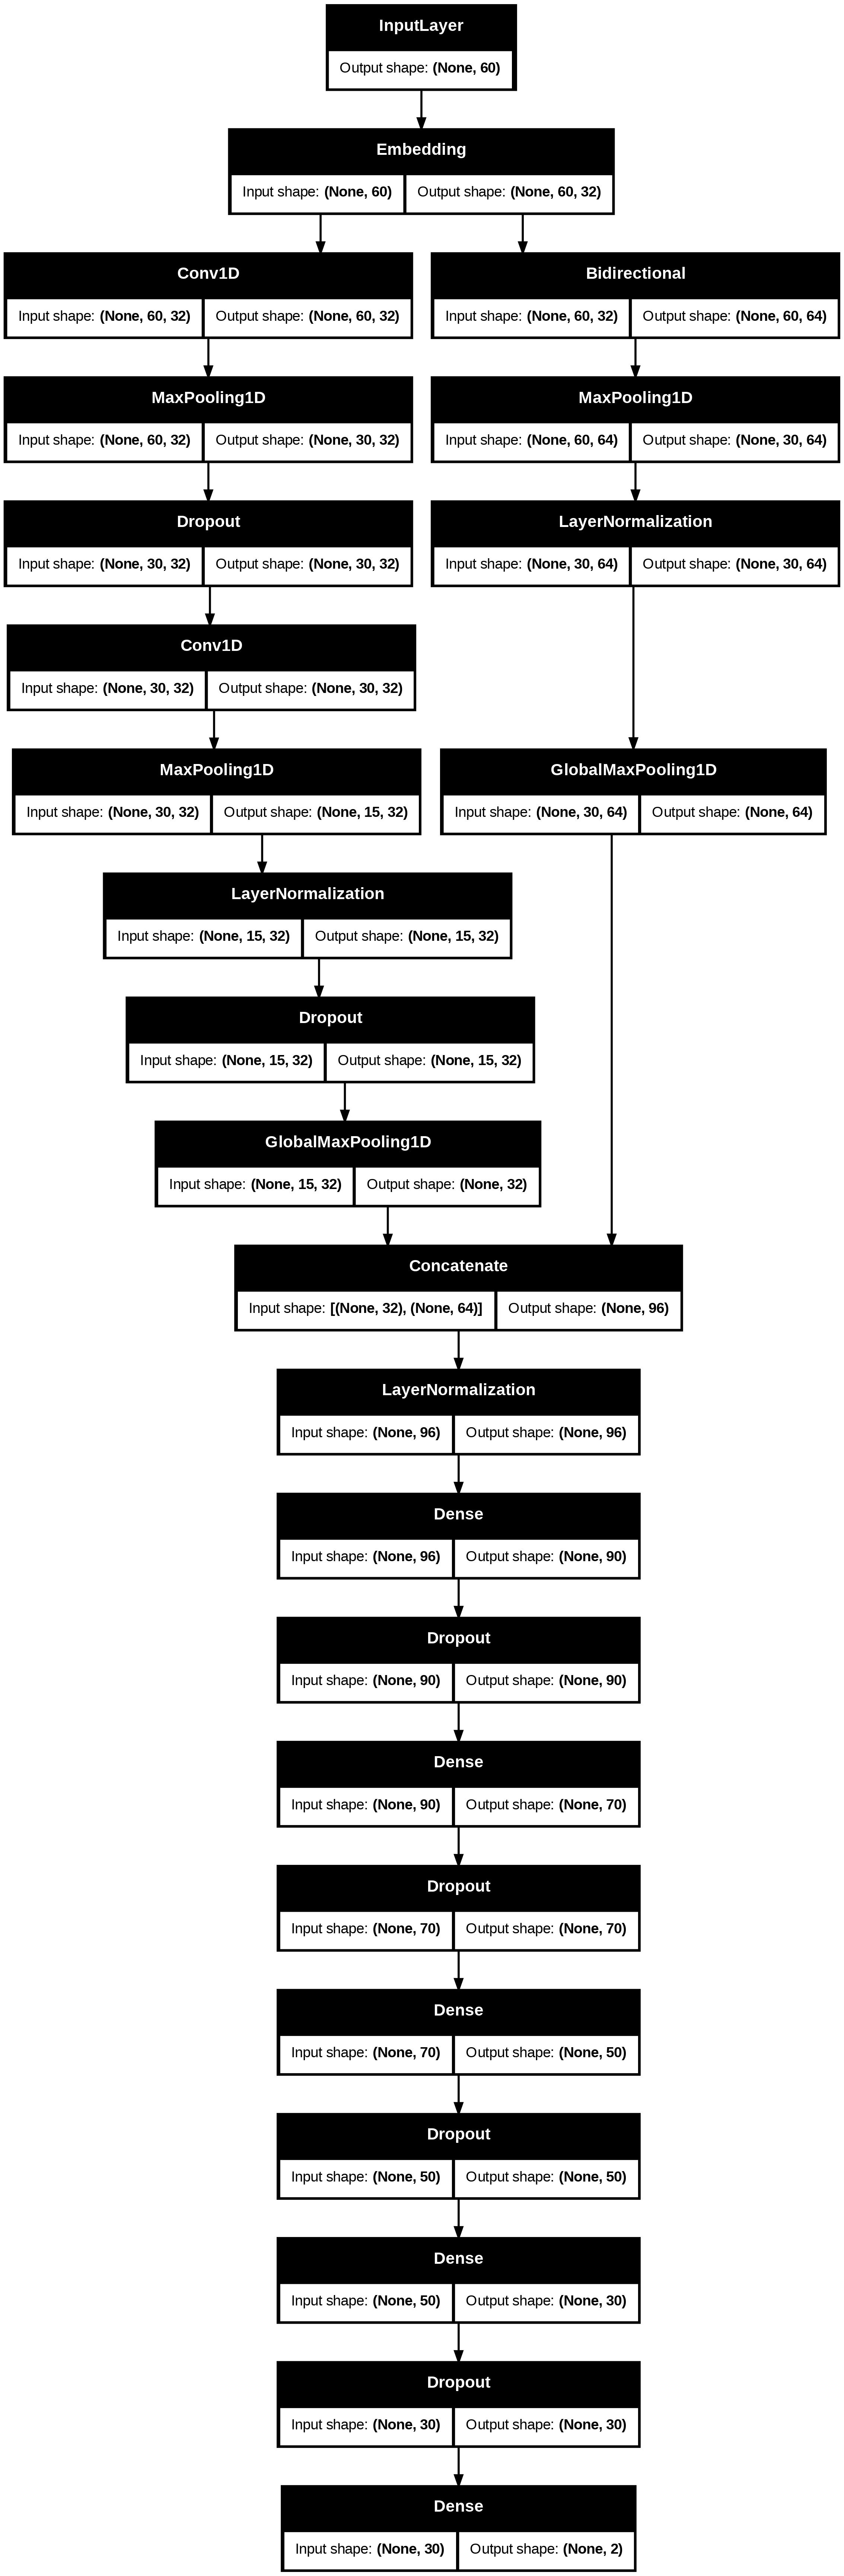

In [ ]:
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [ ]:
# prompt: viết chương trình dùng tenserflow keras load model model_cnn_bilstm_spam.keras .rồi predict

import numpy as np
# Load the trained model
model = load_model('model_cnn_bilstm_spam.keras')

# Example text for prediction (replace with your actual text)
new_text = ["Chào bạn, đây là tin nhắn spam.", "Xin chào, bạn có khỏe không?"]

# Preprocess the new text using the same tokenizer and padding used during training
# Make sure you have the `tokenizer_data` object available from the training phase
new_sequences = tokenizer_data.texts_to_sequences(new_text)
padded_new_sequences = pad_sequences(new_sequences, maxlen=60, padding='post')

# Make predictions
predictions = model.predict(padded_new_sequences)

# Get the predicted class (index of the highest probability)
predicted_classes = np.argmax(predictions, axis=1)

# Map the class index back to the original labels (0 or 1)
# Assuming label_data = {"1": 1, "0": 0} from your previous code
label_map = {v: k for k, v in label_data.items()}
predicted_labels = [label_map[class_index] for class_index in predicted_classes]

# Print the predictions
for text, label, prediction_prob in zip(new_text, predicted_labels, predictions):
    print(f"Text: \"{text}\"")
    print(f"Predicted Label: {'Spam' if label == '1' else 'Not Spam'}")
    print(f"Prediction Probabilities: {prediction_prob}")
    print("-" * 30)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
Text: "Chào bạn, đây là tin nhắn spam."
Predicted Label: Spam
Prediction Probabilities: [2.2023525e-11 1.0000000e+00]
------------------------------
Text: "Xin chào, bạn có khỏe không?"
Predicted Label: Spam
Prediction Probabilities: [0.15101954 0.8489805 ]
------------------------------
